In [1]:
#importing libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import multivariate_normal 
from random import random as rand
import psrf

In [2]:
#For high quality graphs 
mpl.rcParams['figure.dpi']=1000

In [3]:
# seed a random state
rng = np.random.RandomState(0)

In [4]:
# data from the Bioasssay experiment
# x is the log dose level
# n is the number of animals tested on
# y is the number of deaths at that dose level
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

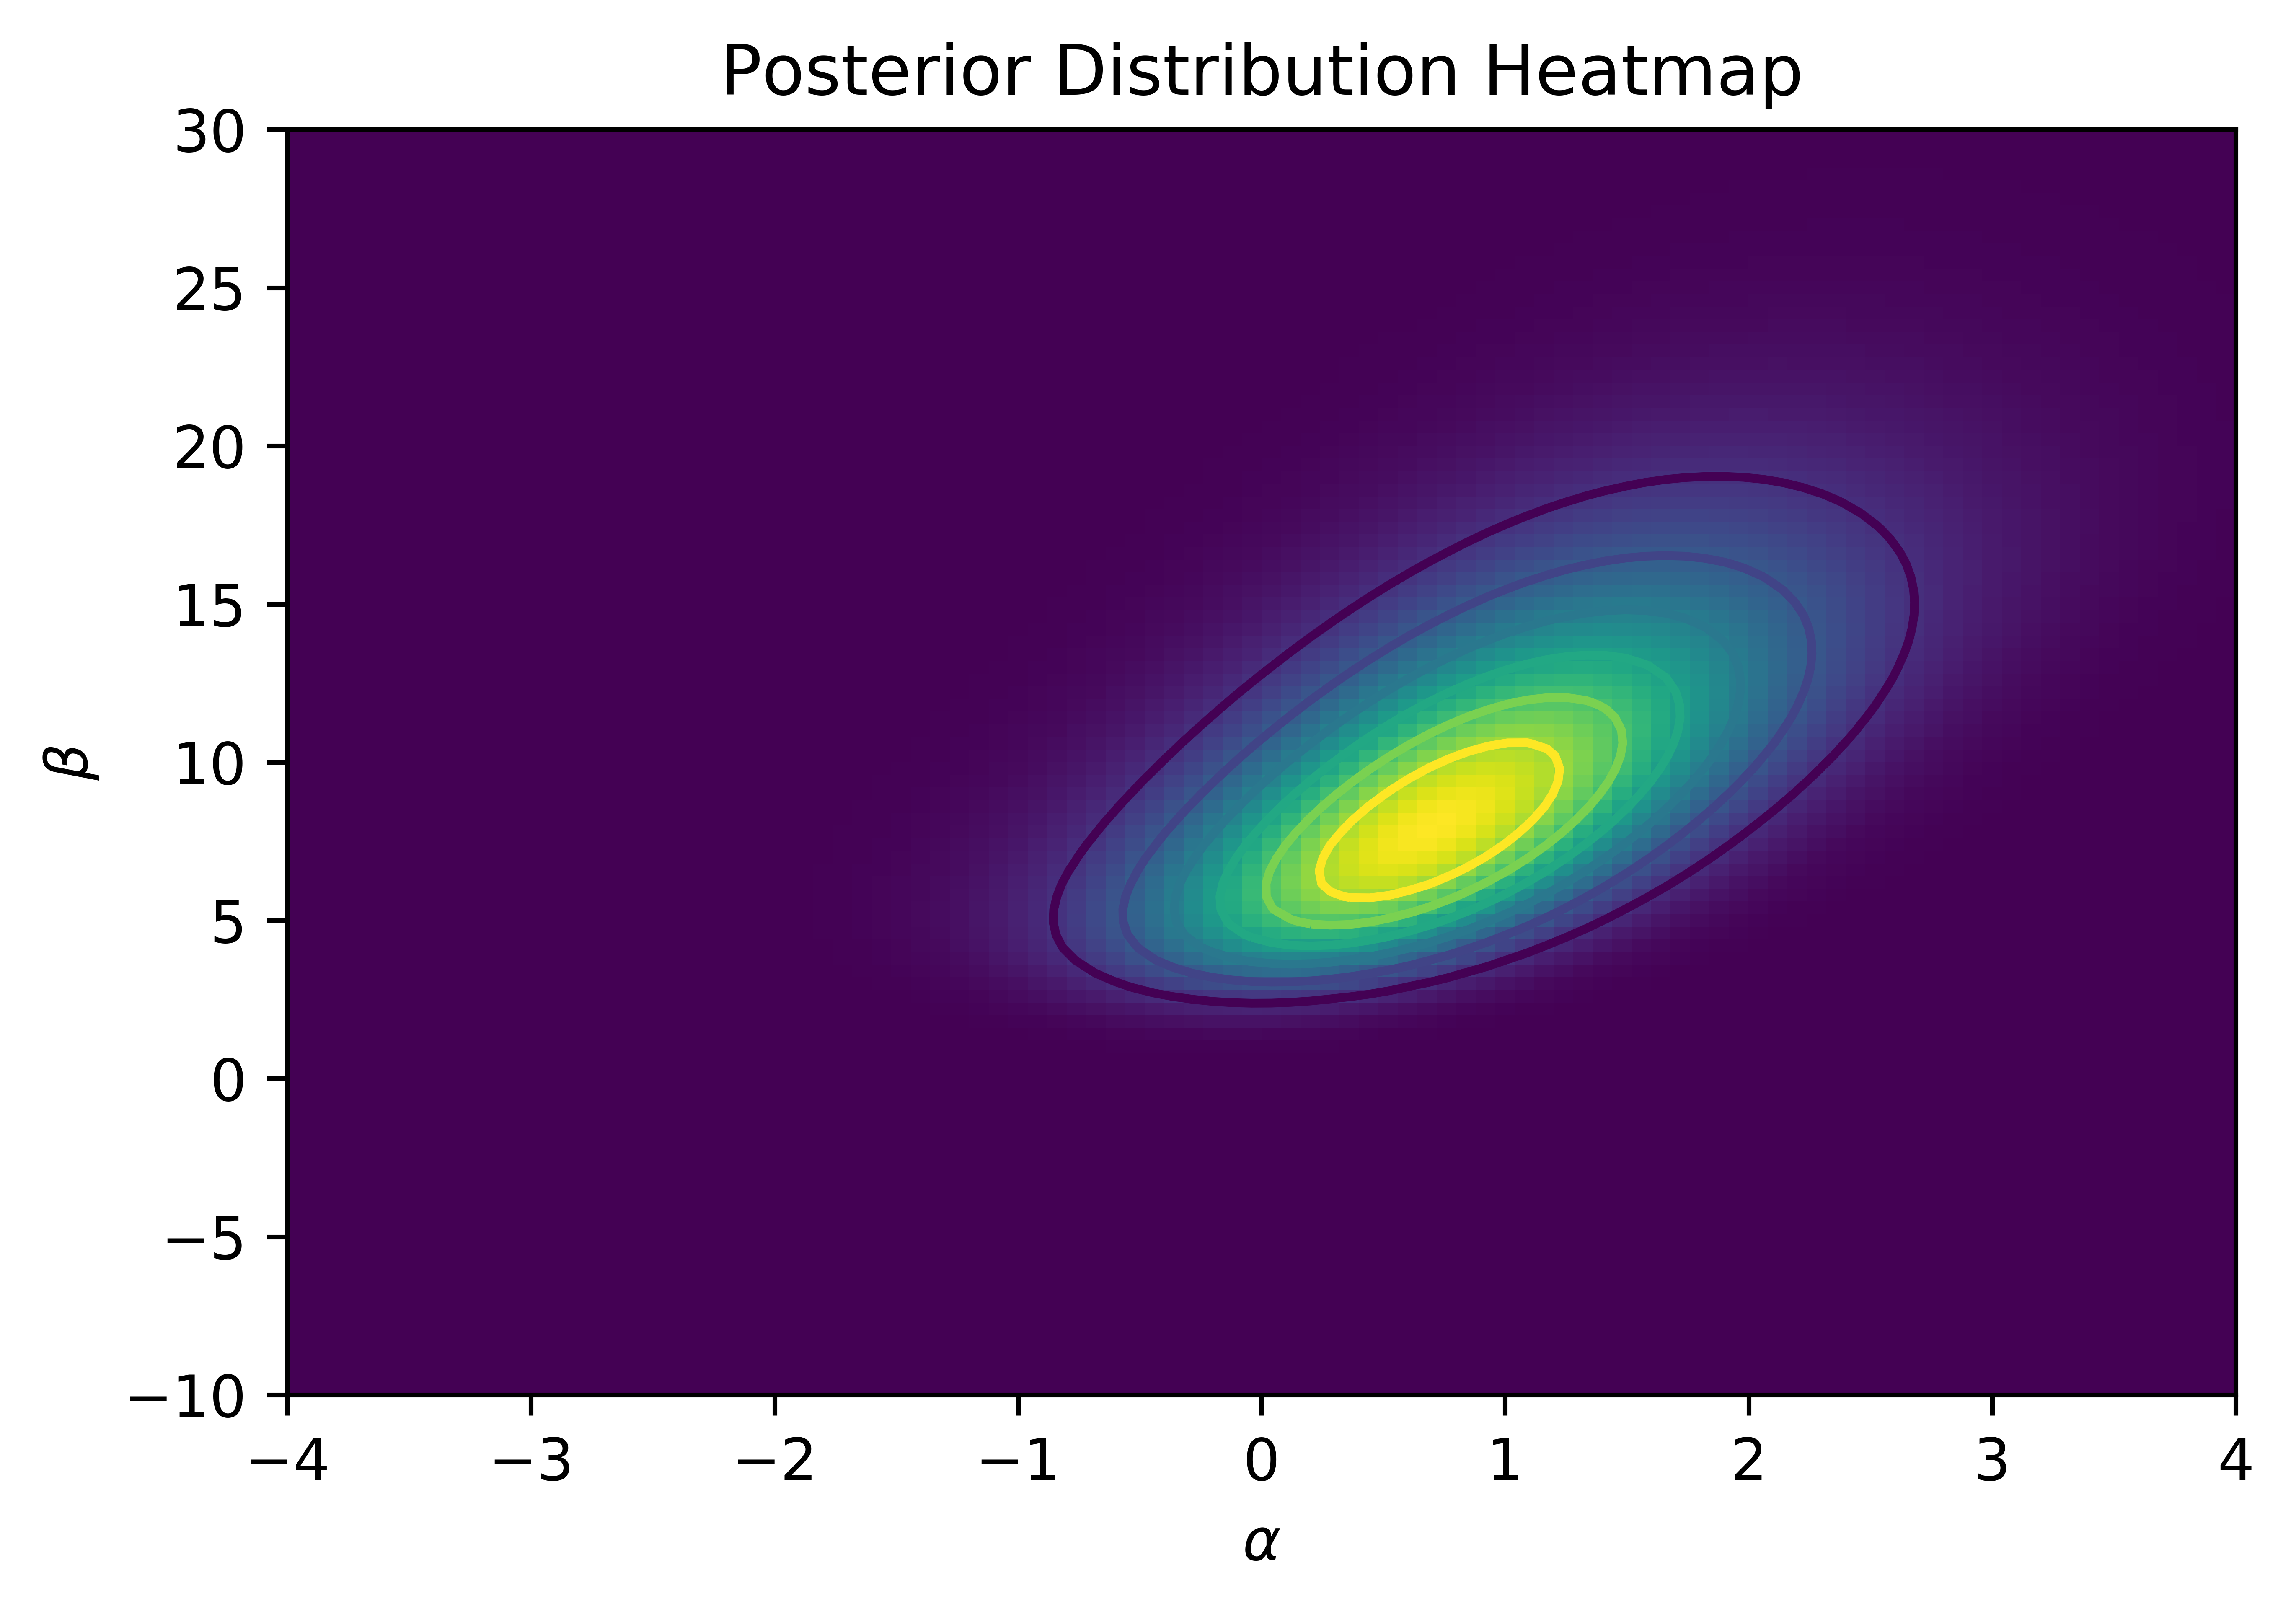

-100.12156562387516

In [5]:
from scipy.stats import multivariate_normal

sigma_a = 2
sigma_b = 10
mu_a = 0
mu_b = 10
p = 0.5

# Creating the mean and covariance matrices for the bivariate normal distribution
mean = np.array([mu_a,mu_b])
covariance = np.array([[sigma_a**2,p*sigma_a*sigma_b],[p*sigma_a*sigma_b,sigma_b**2]])

prior = multivariate_normal(mean,covariance)

A = np.linspace(-4, 4, 100)
B = np.linspace(-10, 30, 100)

def bioassaylp(a,b,x, y, n):
    """Log posterior density for the bioassay problem.
    Given a point(s) and the data, returns unnormalized log posterior density
    for the bioassay problem assuming uniform prior.
    Parameters
    ----------
    a, b : scalar or ndarray
        The point(s) (alpha, beta) in which the posterior is evaluated at.
        `a` and `b` must be of broadcastable shape.
    x, y, n : ndarray
        the data vectors
    Returns
    -------
    lp : scalar or ndarray
        the log posterior density at (a, b)
    """
    # last axis for the data points
    a = np.expand_dims(a, axis=-1)
    b = np.expand_dims(b, axis=-1)
    # these help using chain rule in derivation
    t = a + b*x
    et = np.exp(t)
    z = et/(1.+et)
    # negative log posterior (error function to be minimized)
    log_likelihood = np.sum(y*np.log(z)+ (n-y)*np.log(1.0-z), axis=-1)
    a_b = np.column_stack((a,b))
    log_prior = prior.logpdf(a_b)
    log_posterior = log_prior+log_likelihood
    return log_posterior

xv,yv = np.meshgrid(A,B)
pos = np.empty(xv.shape + (2,))
pos[:, :, 0] = xv; pos[:, :, 1] = yv


pos_arr = pos.reshape(100*100,2)
log_posterior = (bioassaylp(pos_arr[:,0],pos_arr[:,1],x,y,n)).reshape(100,100)
posterior = np.exp(log_posterior)


plt.imshow(posterior,origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]))
plt.contour(A,B,posterior)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Posterior Distribution Heatmap')
plt.show()

bioassaylp(-4,-10,x,y,n)


In [6]:
# How many samples to ignore as burn in 
burn_in = 5000
# How many samples to generate
no_samples = 5000

def metropolis(theta_0,target=bioassaylp,burn_in=burn_in,no_samples=no_samples):

    lim =no_samples+burn_in

    theta = np.zeros((lim,2))
    


    #Setting initial value to theta_0
    theta[0]=theta_0

    #Loop counter
    i=1

    #Covariance for the jump matrix
    cov = [[1,0],[0,5]]

    #Metropilis Algorithm
    while i <lim:
        theta_temp = multivariate_normal(mean=theta[i-1],cov=cov).rvs(1)
        r = np.exp(target(theta_temp[0],theta_temp[1],x,y,n)-target(theta[i-1][0],theta[i-1][1],x,y,n))
        prob = min(1,r)
        u = rand()

        # Accept theta_temp with probability prob
        if(u<=prob):
            #print("theta pred: {0} Accepted , r = {1}, prob = {2}, u = {3}".format(theta_temp,r,prob,u))
            theta[i]=theta_temp
        # Reject theta_temp with probability 1-prob
        else:
            #print("theta pred: {0} Rejected , r = {1}, prob = {2}, u = {3}".format(theta_temp,r,prob,u))
            theta[i]=theta[i-1]
        i+=1
    
    return theta





## Chains, Starting Point and other details
There were 4 chains taken to run this simulation of Metropolis Algorithm. Their details are:
1. Chain 1
   * Starting Point : $(\alpha,\beta) = (-10,14) $
   * Burn-in Length : 5000
   * Number of samples: 5000
   * Jumping Distribution: $J(\theta^*|\theta^{t-1}) \sim N\left(\mu = \theta^{t-1}, \Sigma =   \begin{bmatrix}
    1 & 0 \\
    0 & 5
  \end{bmatrix}\right)$
2. Chain 2
   * Starting Point : $(\alpha,\beta) = (4,30) $
   * Burn-in Length : 5000
   * Number of samples: 5000
   * Jumping Distribution: $J(\theta^*|\theta^{t-1}) \sim N\left(\mu = \theta^{t-1}, \Sigma =   \begin{bmatrix}
    1 & 0 \\
    0 & 5
  \end{bmatrix}\right)$
3. Chain 3
   * Starting Point : $(\alpha,\beta) = (-4,40) $
   * Burn-in Length : 5000
   * Number of samples: 5000
   * Jumping Distribution: $J(\theta^*|\theta^{t-1}) \sim N\left(\mu = \theta^{t-1}, \Sigma =   \begin{bmatrix}
    1 & 0 \\
    0 & 5
  \end{bmatrix}\right)$
4. Chain 4
   * Starting Point : $(\alpha,\beta) = (1,50) $
   * Burn-in Length : 5000
   * Number of samples: 5000
   * Jumping Distribution: $J(\theta^*|\theta^{t-1}) \sim N\left(\mu = \theta^{t-1}, \Sigma =   \begin{bmatrix}
    1 & 0 \\
    0 & 5
  \end{bmatrix}\right)$

In [10]:
chains = []
starting_points = [[-10,14],[4,30],[-4,40],[1,50]]
for theta_0 in starting_points:
    chains.append(metropolis(theta_0=theta_0)[burn_in:])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply


In [11]:
R = psrf.psrf(chains)
print("R-hat value of aplha:{0}".format(R[0]))
print("R-hat value of beta :{0}".format(R[1]))

R-hat value of aplha:1.003663466182623
R-hat value of beta :1.0071724468884706


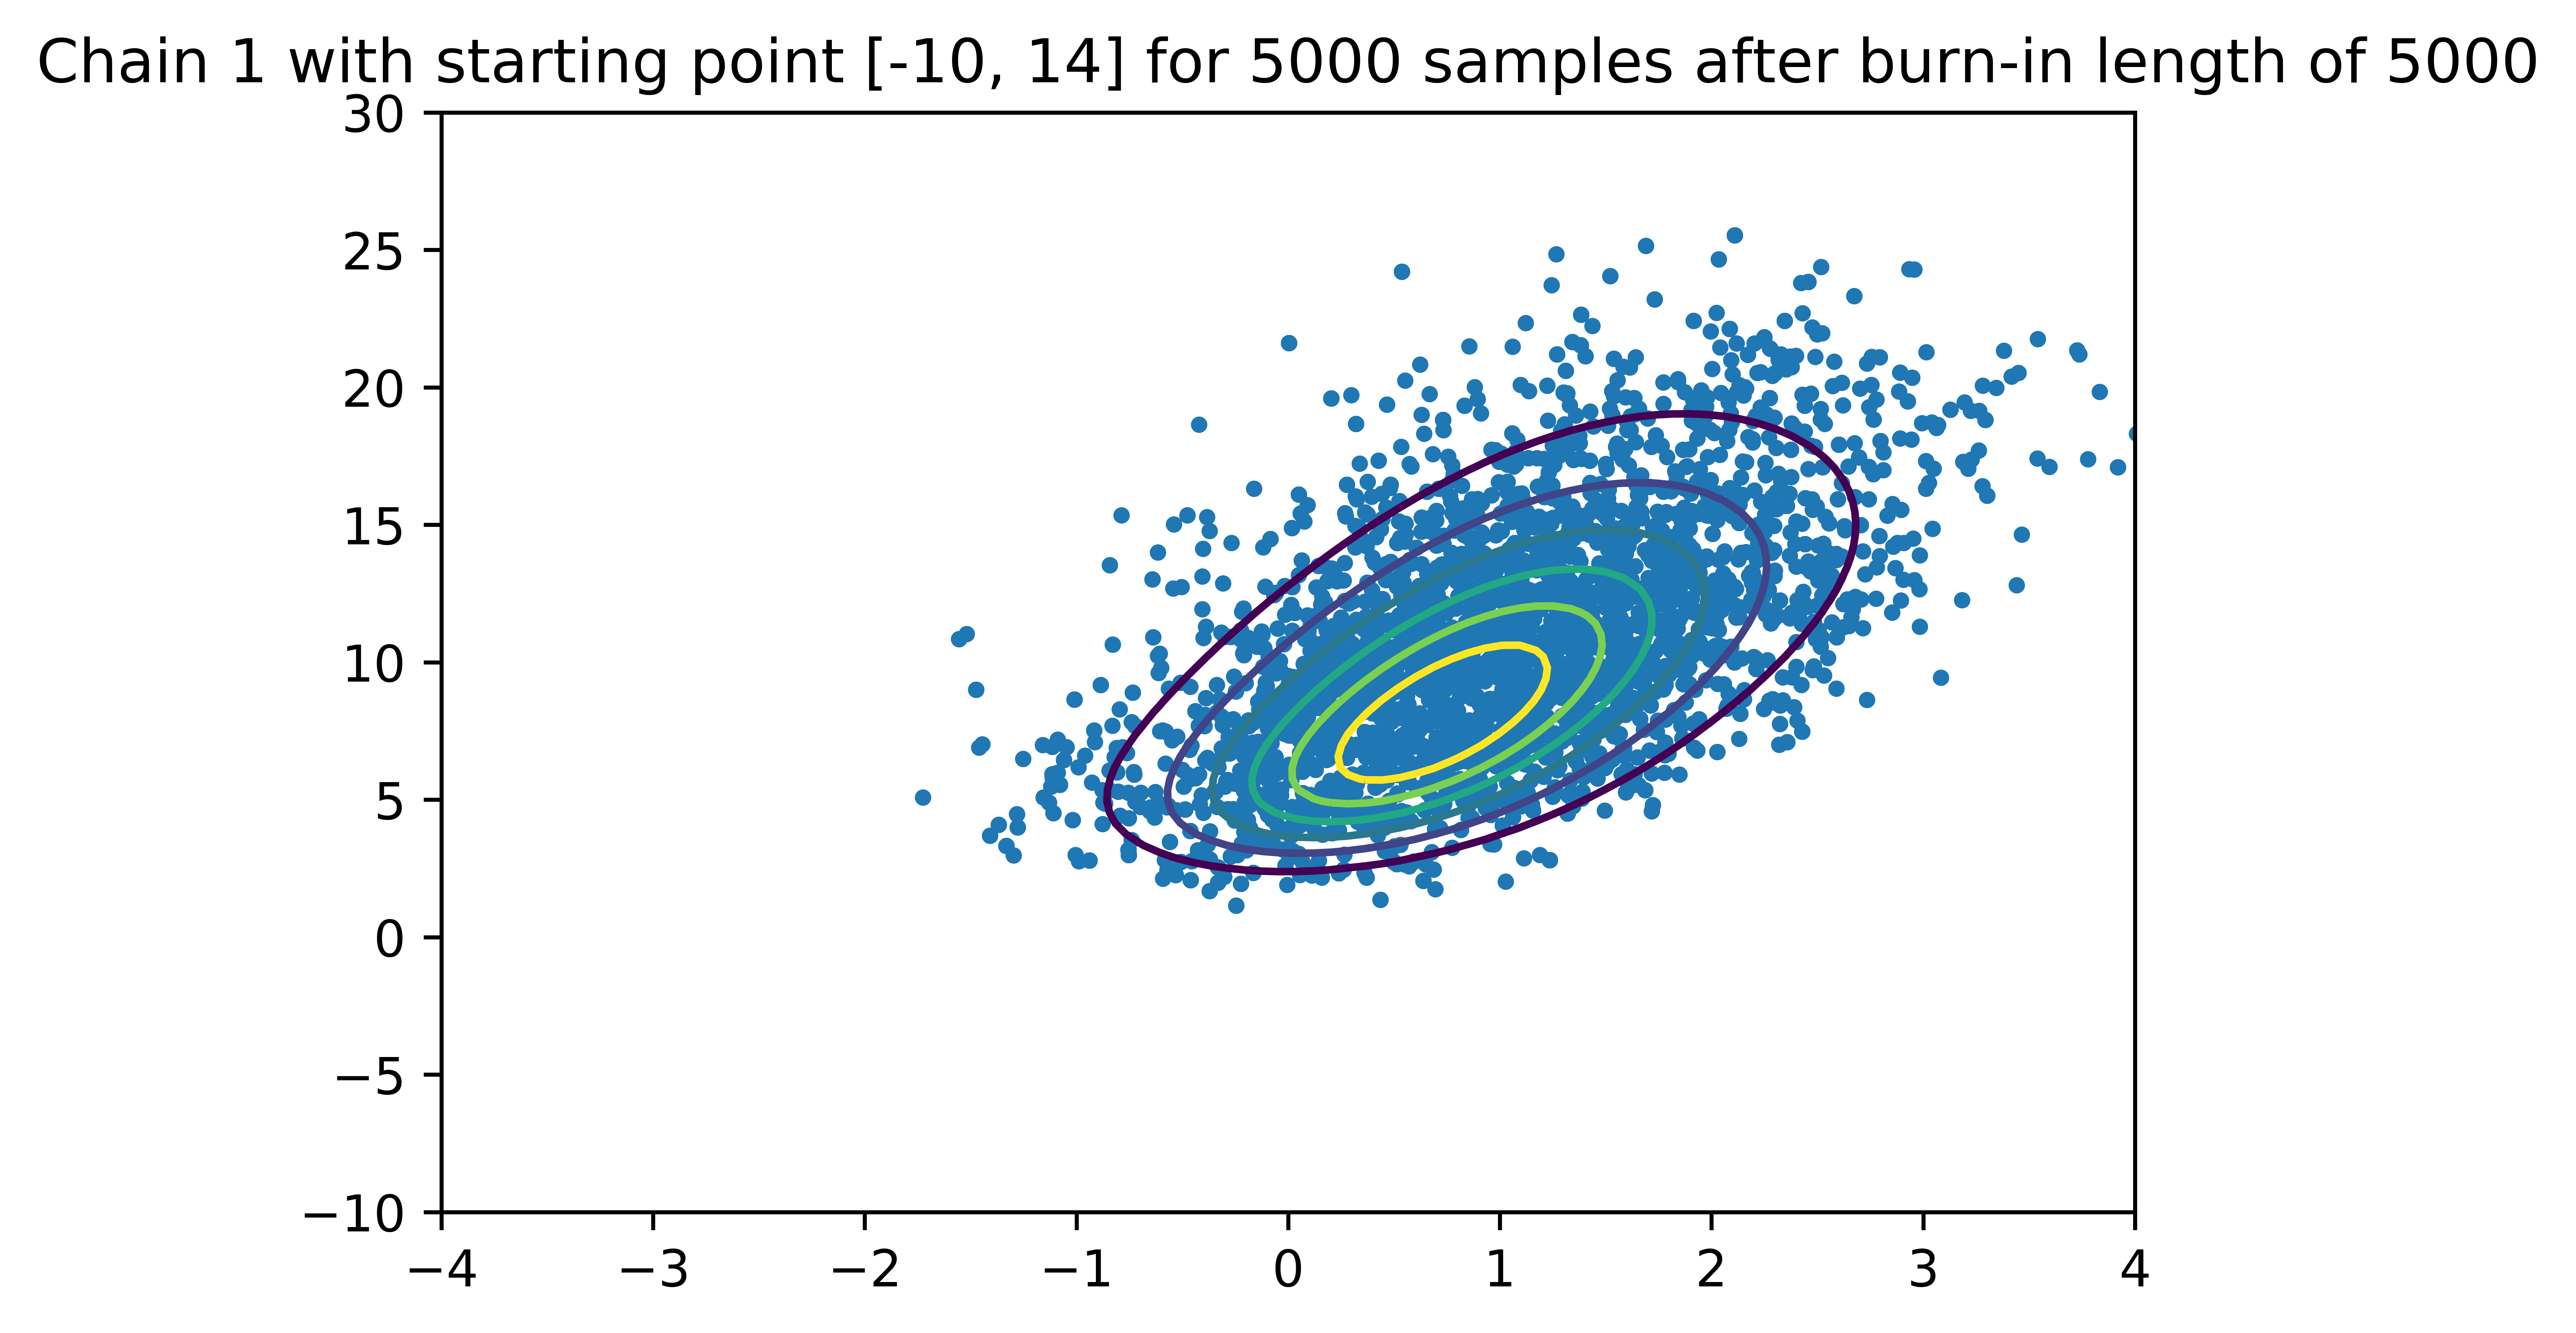

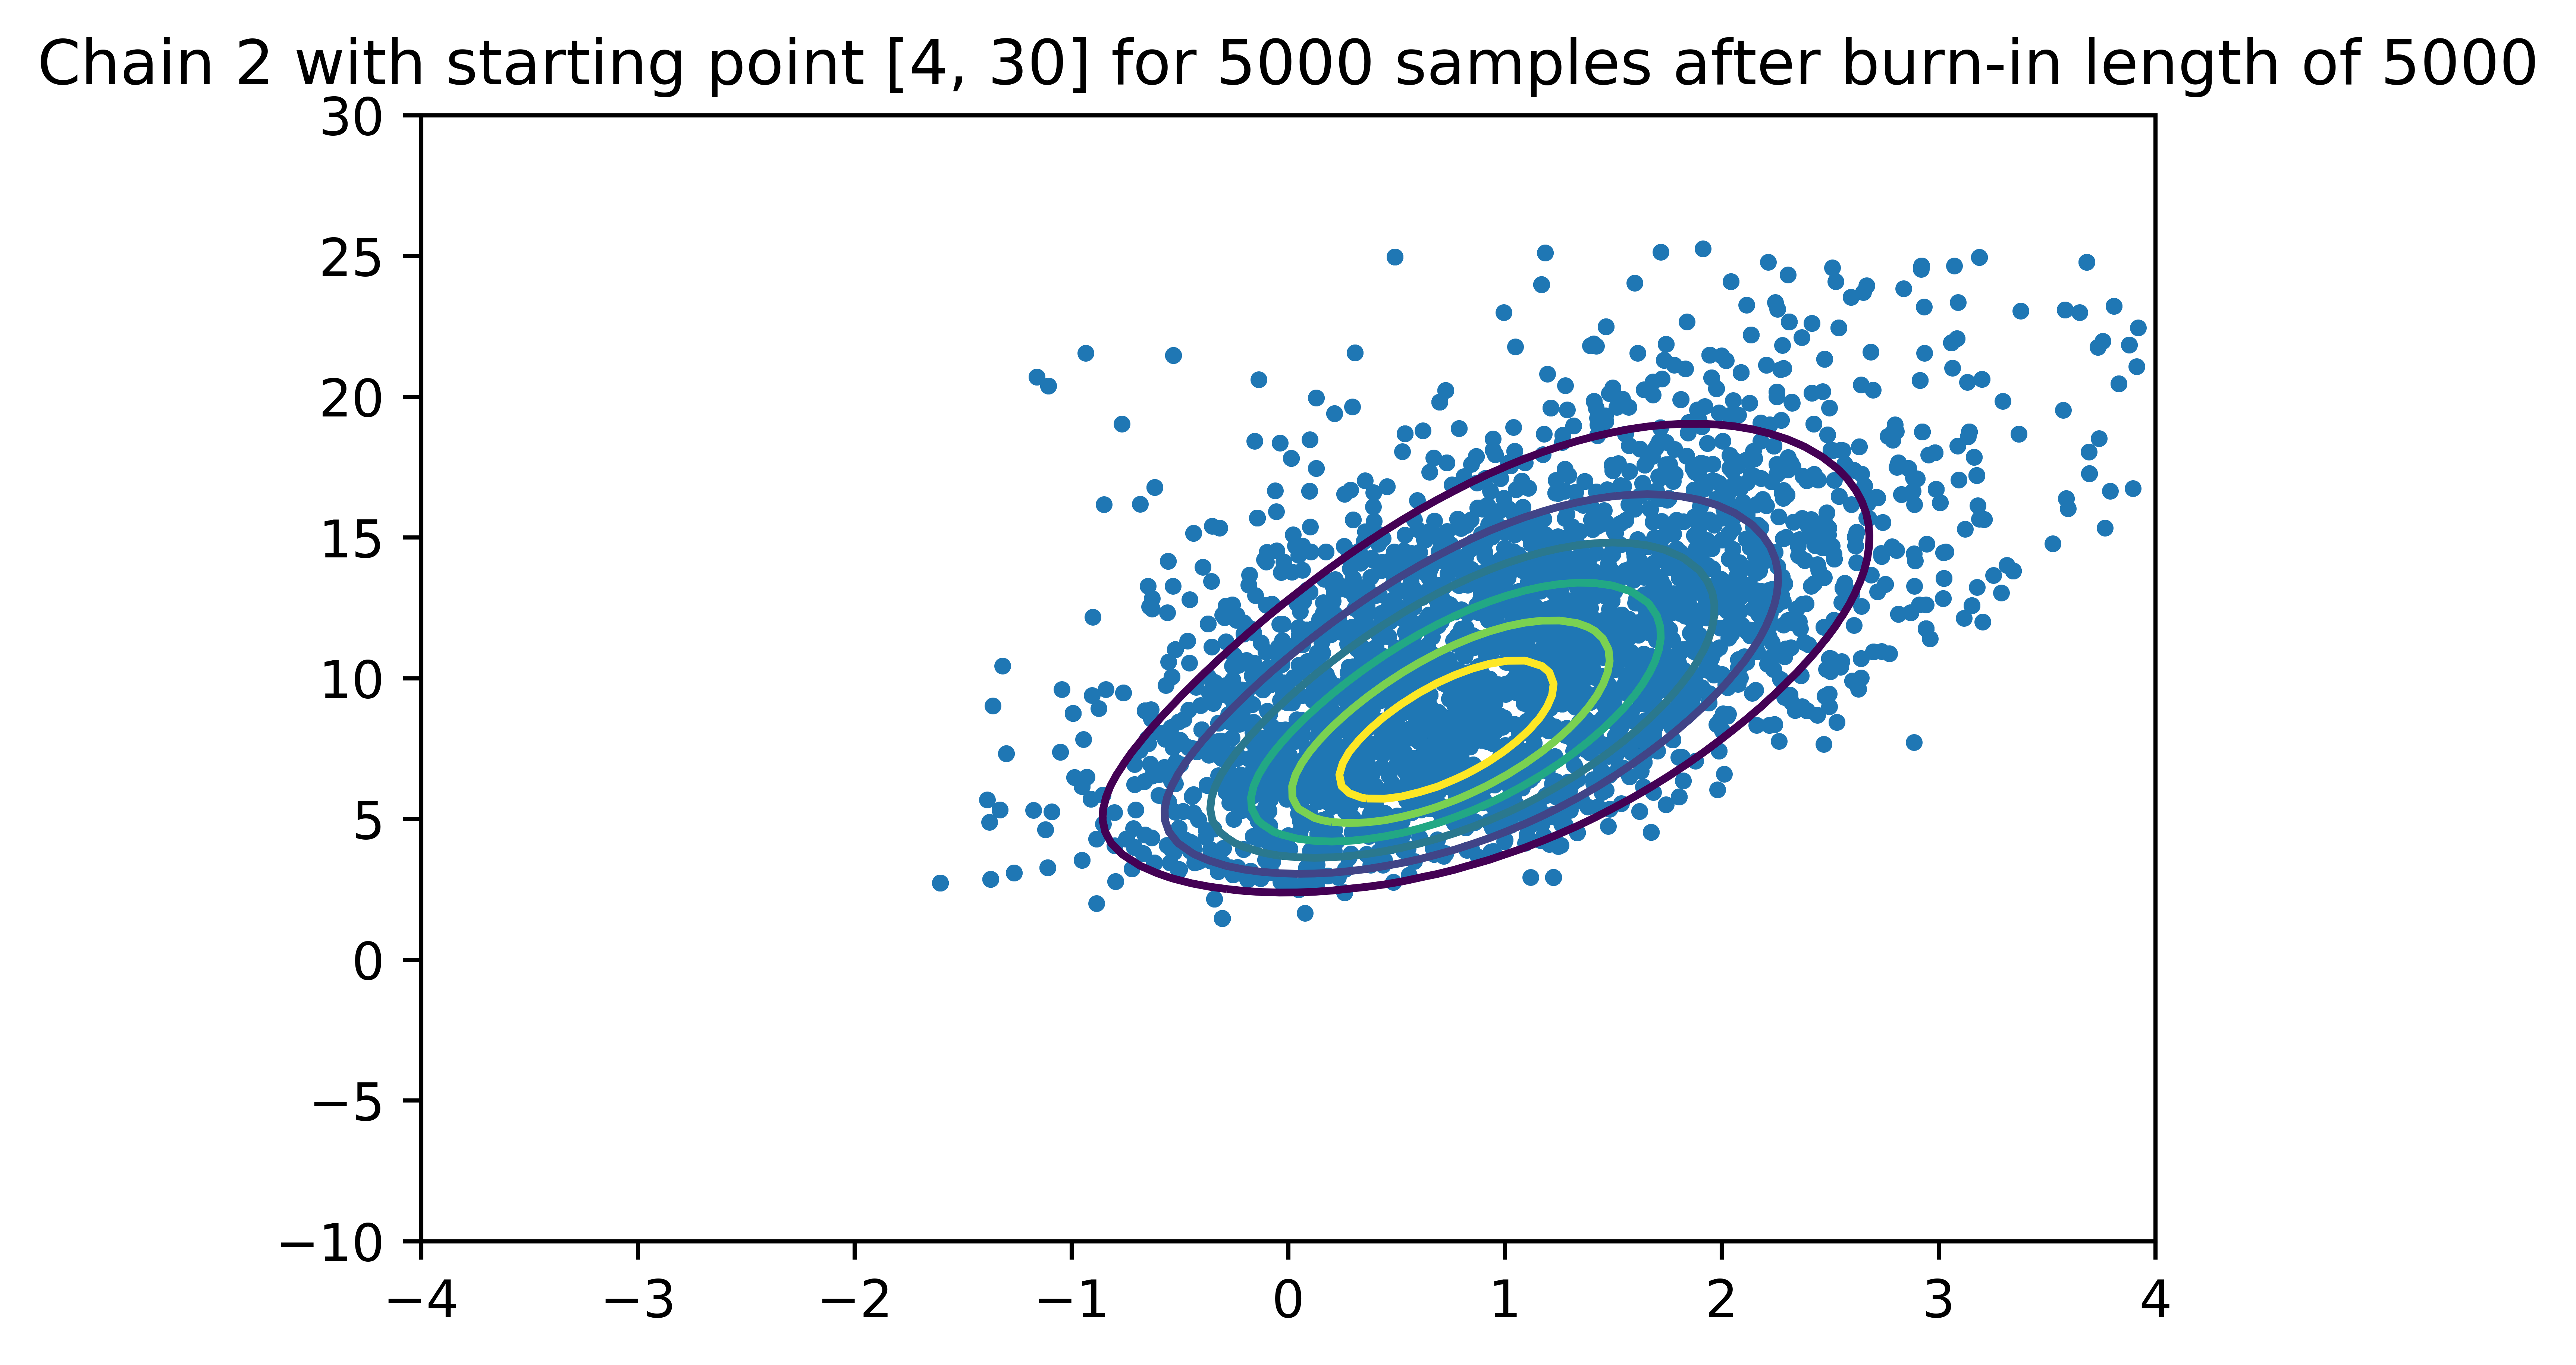

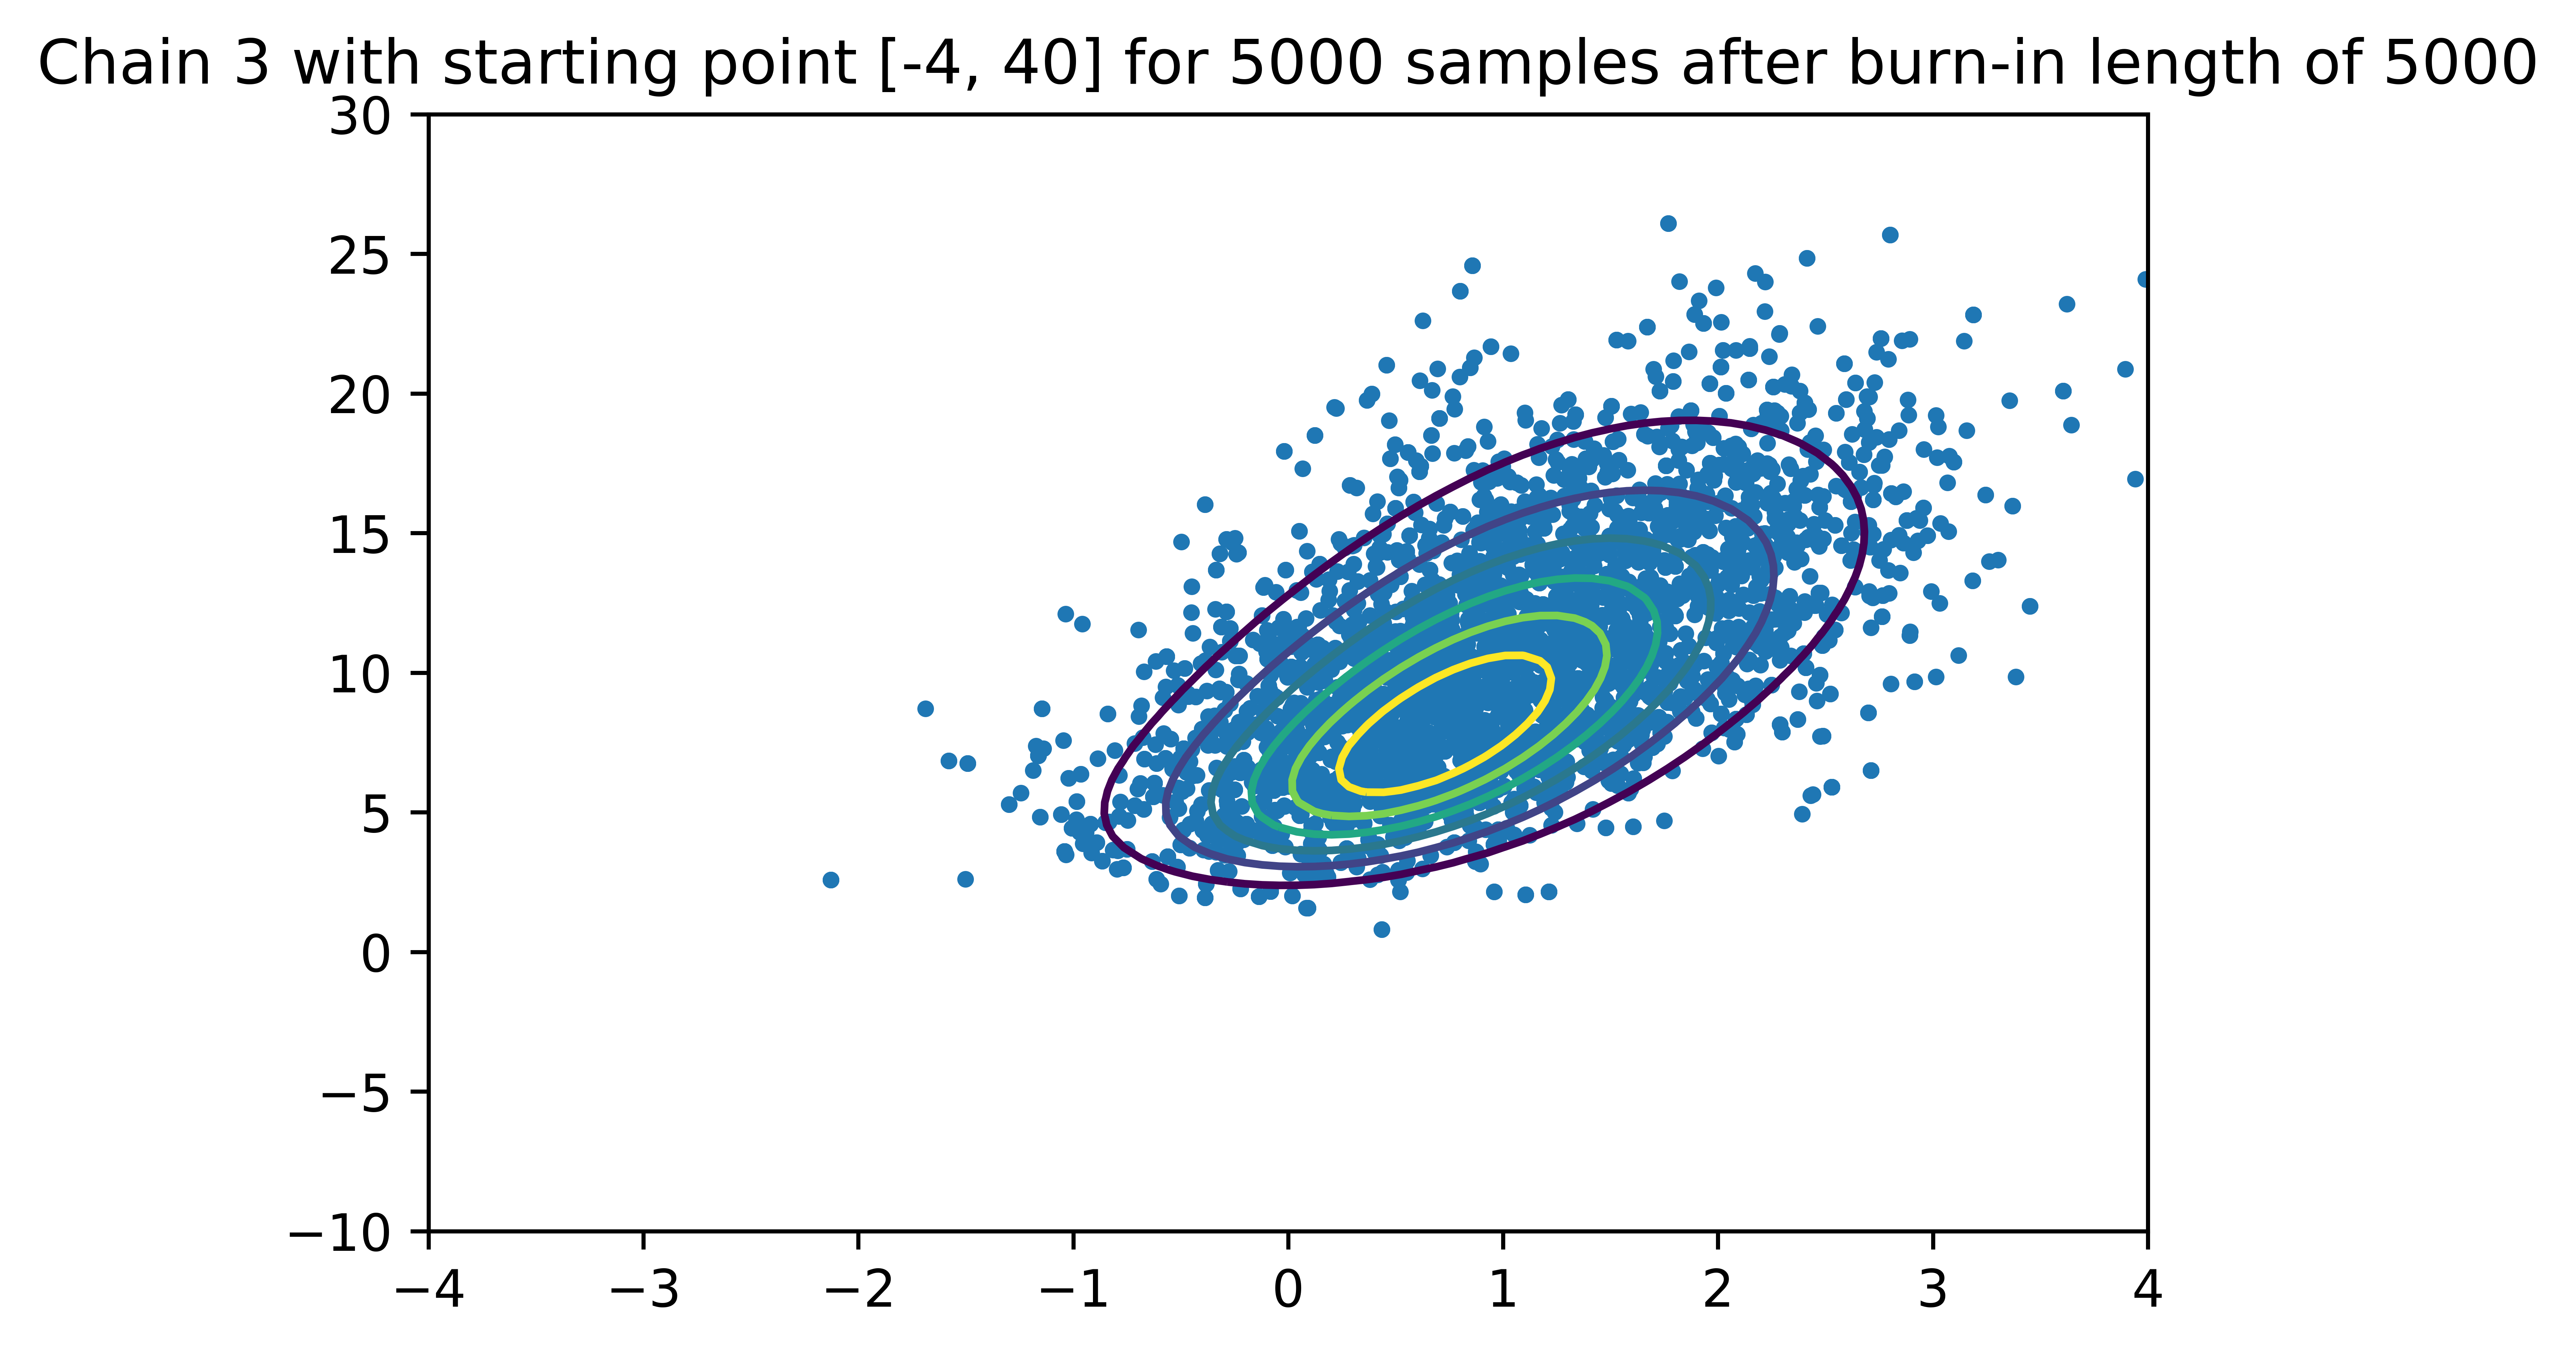

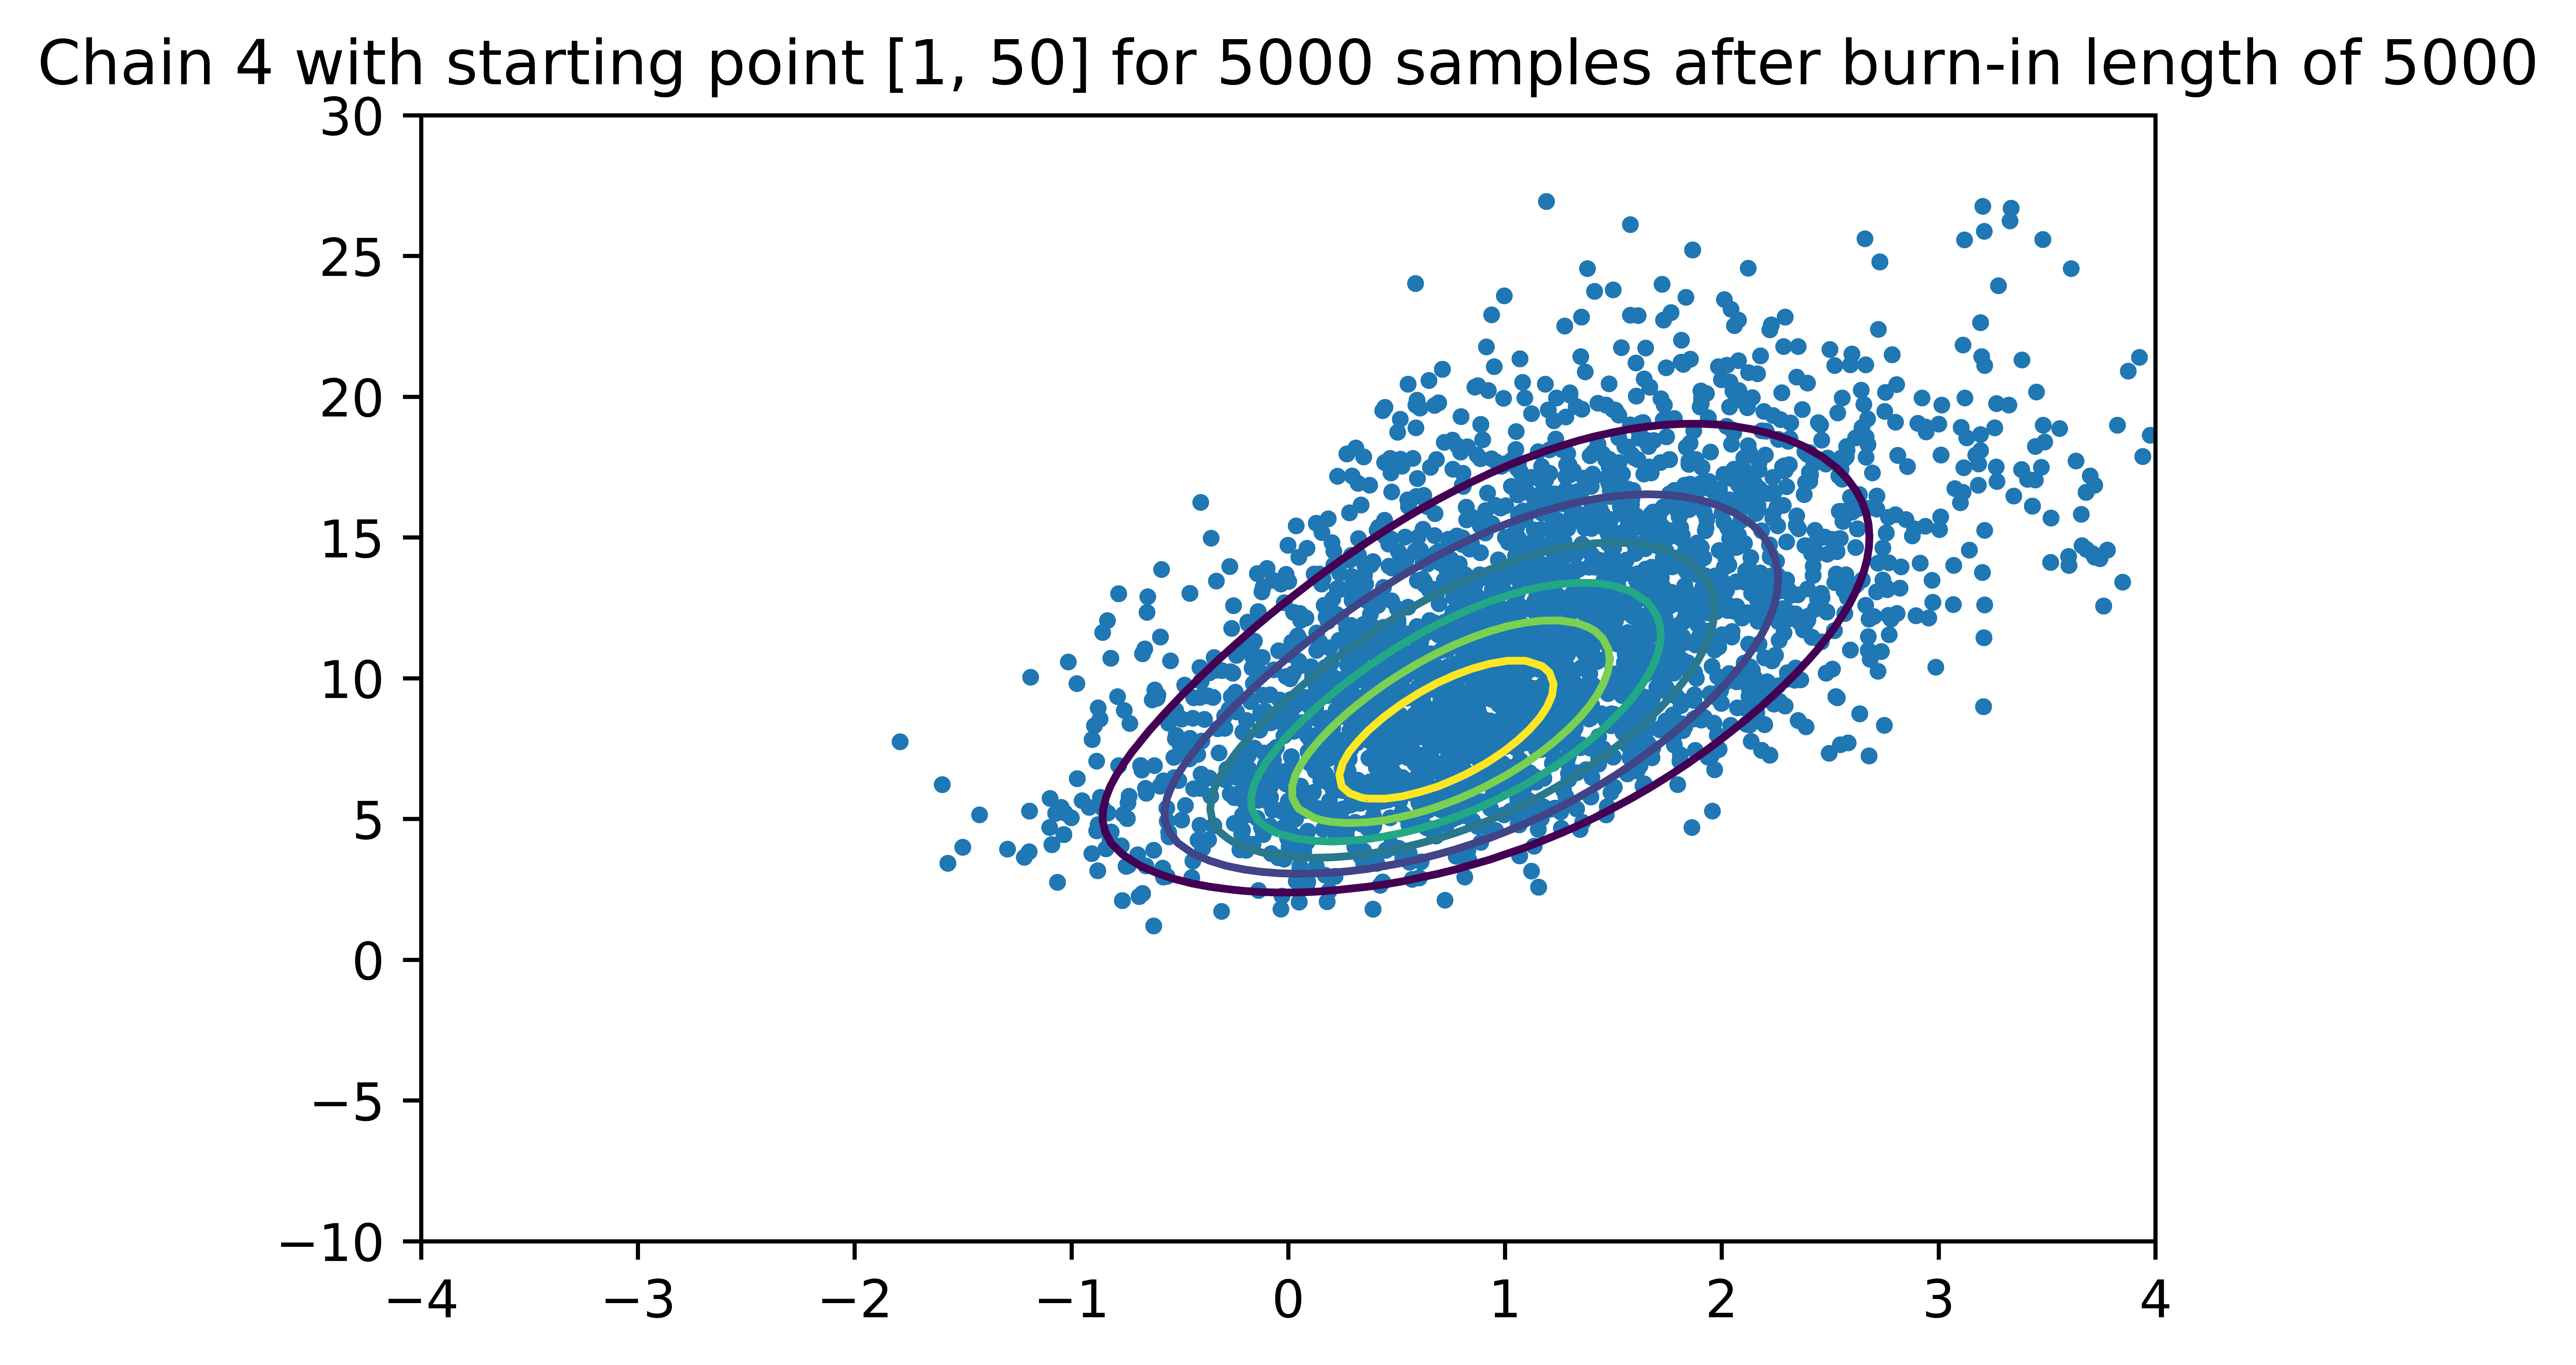

In [12]:
for i in range(len(chains)):
    plt.scatter(chains[i][:,0],chains[i][:,1],5)
    plt.contour(A,B,posterior)
    plt.xlim([-4,4])
    plt.ylim([-10,30])
    plt.title("Chain {0} with starting point [{1}, {2}] for {3} samples after burn-in length of {4}".format(
        i+1,starting_points[i][0],starting_points[i][1],no_samples,burn_in))
    plt.show()
